In [5]:
# libraries we need
import torch # Pytorch - hopefully it's clear why we need this
import numpy as np # Numpy - useful for data manipulation.
import matplotlib.pyplot as plt # Lets us display data
import torchvision # We use this for the dataset we'll use
# By importing torch we can already access these - this is just a convenience thing
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm # Lets us see loop progress

In [6]:
#An essential feauture of pytorch is its ability to utlize GPUs and TPUs
#This portion of the code chooses the device that while be used,
#if there is a GPU that uses the CUDA toolkit, then it will utlize it
#if not it will use the CPU for calculations
#Note many times, GPUs are much faster option, and allow for more realistic training times

if torch.cuda.is_available(): # Checks if CUDA is availiable, loads the device for computation to the GPU
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on CPU


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([3, 32, 32])


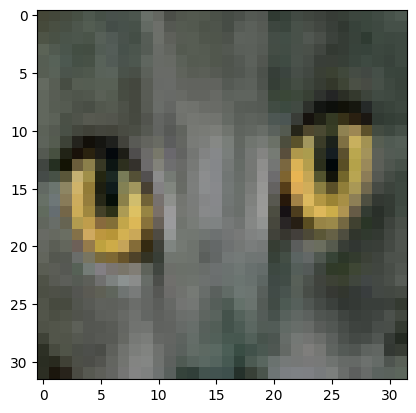

In [7]:
# download the CIFAR 10 training and testing data sets from torchvision.datasets
# There are a set of datasets that are stored on server for pytorch, anyone can donwload them if they have pytorch set up
# They are split to training and test dataset, which do not intersect!
# If you were doing this with your own dataset, you would have to make your own dataset!
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10', transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, transform=torchvision.transforms.ToTensor(), download=True)

#The dataloader class makes it easy for us to handle and randomize data
#The train and test loader both have a 128 sized batches of images, and are shuffled to increase randomization(improves performance)
train_loader = torch.utils.data.DataLoader(train_dataset, 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 128, shuffle=True)

# visualizing a sample from train loader
print(train_dataset)

# Extracting an image and label from the dataset
train_iter = iter(train_loader)
batch_images, batch_labels = next(train_iter)
# The label is a number between 0 and 9 - why might that be?  Isn't the label a category, not a number?
# The image is represented as a 3 by 32 by 32 matrix (A 3-dimensional array)
image, label = batch_images[0], batch_labels[0]

print(image.shape)
plt.imshow(image.permute(1, 2, 0)) # Hmmm... this gives us an error.  How might we fix this?  What is causing the error?
# HINT: - look into what permute does, and think about the dimensions of the image
plt.show()

In [8]:
#This is a class module for to create a CNN, not the Module class in pytorch
#Is the base class for all models in pytorch, this contains the inner working of a module

#Functions ->
# The def __init__(self) is a constructor, where you outline the different layers and aspects of your custom class
# def forward is the function for forward propogationm you give it an input X and it outputs tensore

#Layers ->
#In pytorch a nn.Conv2d layer is a convolution 2d layer, the arguments are as follows
#nn.Conv2d(Number of Input features maps, Number of features maps, Kernel Size, Stride Size, Padding Size )
#nn.BatchNorm2d is a batch normalization layer that takes in a 2d tensor the argument is the number of input feature maps

#Hint ->
#There is going to be a lot of repitition in your code - it's supposed to look like that, don't worry
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional layer
        # Here we're defining a standard layer with Convolution, BatchNorm, and dropout
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2) # b x 3 x 32 x 32 -> b x 32 x 16 x 16
        self.batchnorm1 = nn.BatchNorm2d(32);
        self.relu1 = nn.ReLU() # Using ReLU activation function
        self.dropout1 = nn.Dropout(0.1)# Adding dropout to prevent overfitting (recommend a rate of 0.1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)# b x 32 x 16 x 16 -> b x 64 x 8 x 8
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2) # Adding a pooling layer to reduce spatial dimensions, b x 64 x 8 x 8 -> b x 64 x 4 x 4
        self.dropout2 = nn.Dropout(0.05)# Recommend rate of 0.05

        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)# b x 64 x 4 x 4 -> b x 64 x 4 x 4
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.05) # Recommend rate of 0.05
        self.flatten = nn.Flatten()  # b x 64 x 4 x 4 -> b x (64 * 4 * 4)

        # Fully connected layer - classifying the features into 10 classes
        self.fc = nn.Linear(64 * 4 * 4, 128) # 64 from the last conv layer, 10 for the number of classes, b x (64 * 4 * 4) -> b x 128
        self.relu4 =  nn.ReLU()
        self.fc1 = nn.Linear(128, 10)  # b x 128 -> b x 10 - left this one in as a hint ;)

    # This is already done - we're just calling the functions we define
    def forward(self, x):
        # Describing the forward pass through the network
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)


        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        # After all those conv layers we can finally pass into a fully connected layer
        # Think about it like the neural network does a bunch of pre processing to make the image easier to understand before looking at it
        x = self.flatten(x)  # Flattening the output of the conv layers for the fully connected layer
        x = self.fc(x)
        x = self.relu4(x)
        x = self.fc1(x)
        return x  # The softmax (or another activation) can be implicitly applied by the loss function

In [9]:
# We are creating an instance of our CNN model, after which we load to model to
# the device either GPU or CPU
model = CNN()

model.to(device)

#This is where we define our loss, in this case the loss is cross entorpy
#Remember - the loss is a number that tells our model how good it's doing.  The specifics of how this works are a theory track topic
criterion = nn.CrossEntropyLoss()

#We define the optimizer here, the model.paramters() ar all the paramters of our model, lr is the learning rate
#Again, the specifics of how this optimizer works are a theory track topic
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

In [10]:
#This is the training loop, it will take the model, train loader, the optimizer and device
#It loops through each training data and trains the model
#Note the data is loaded in batches not single instances, this is important
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    for i, batch in tqdm(enumerate(train_loader)):  # looping through
        inputs, labels = batch # The bacth contains the inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)#
        loss = criterion(outputs, labels) # Error is calculated here, by the criterion(ie cross entropy loss)
        loss.backward()  # Computes the gradients and stores it in the model parameters' .grad attribute (this is backprop! or autodiff)
        optimizer.step() # Updates the weights to their new value(gradient update)
        optimizer.zero_grad()# Zeros out the gradients for next iteration
    print('End of epoch loss:', round(loss.item(), 3))

In [11]:
#This is the same as above except that there is no optimization just testing for accruacy
@torch.no_grad()
def test(model, test_loader, device):
    # we've manually specified the classes - these are from the cifar-10 dataset
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # what is the first thing to do before testing?
    model.eval()
    correct = 0
    for i, batch in tqdm(enumerate(test_loader)):
         inputs, labels = batch
         inputs = inputs.to(device)
         labels = labels.to(device)
         outputs = model(inputs)
         predictions = outputs.argmax(dim=1)  # We take the maximum of the predictions, we take the max probability
         correct += (predictions == labels).sum().item()

    print(f"End of epoch accuracy: {100 * correct / len(test_dataset)}%")

    # visualizing the current model's performance
    for i in range(min(len(inputs), 8)):
        print('Guess:', classes[predictions[i]], '| Label:', classes[labels[i]])
        plt.imshow(inputs[i].cpu().permute(1,2,0))
        plt.show()

Epoch:  1


0it [00:00, ?it/s]

End of epoch loss: 1.354


0it [00:00, ?it/s]

End of epoch accuracy: 53.66%
Guess: dog | Label: bird


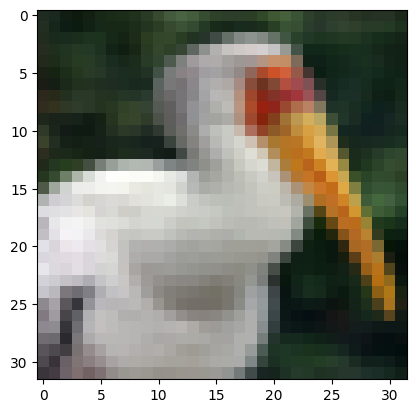

Guess: deer | Label: bird


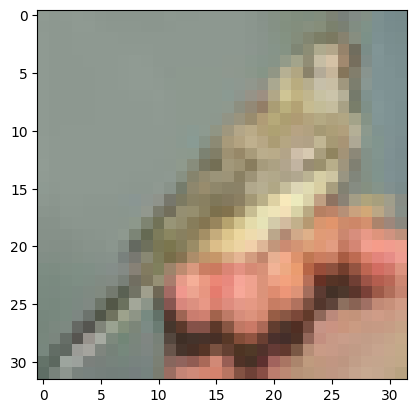

Guess: dog | Label: dog


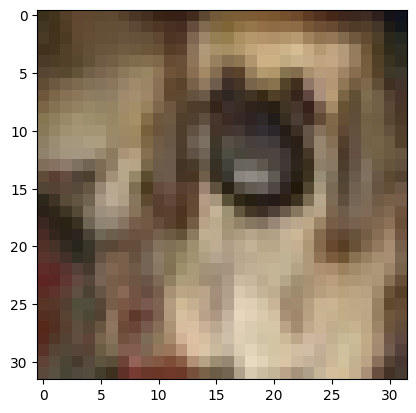

Guess: plane | Label: cat


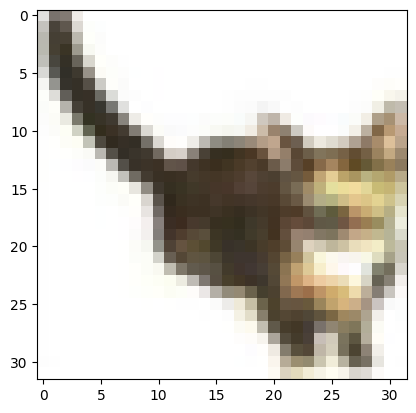

Guess: car | Label: car


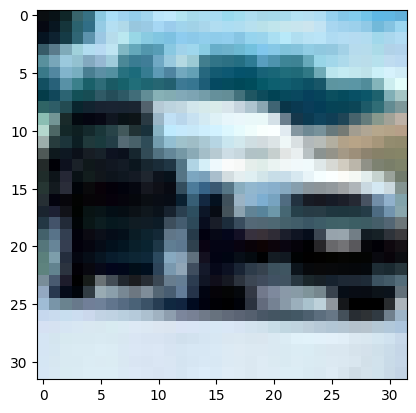

Guess: deer | Label: frog


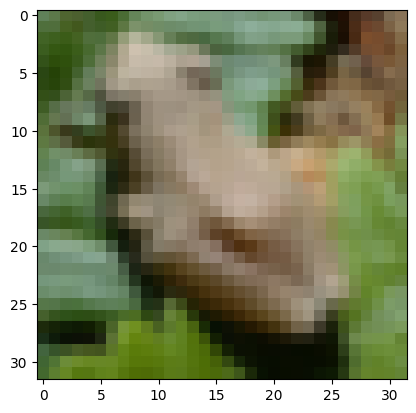

Guess: truck | Label: car


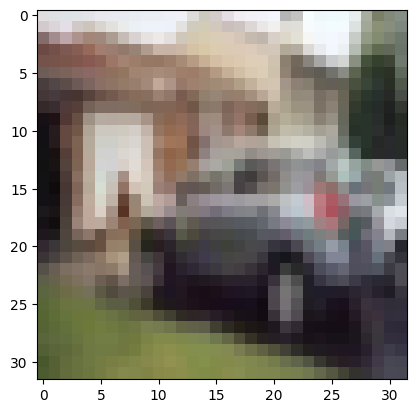

Guess: truck | Label: car


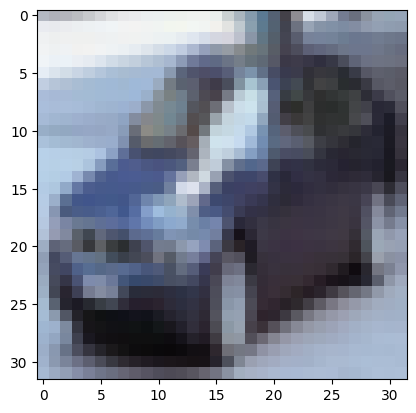

Epoch:  2


0it [00:00, ?it/s]

End of epoch loss: 1.219


0it [00:00, ?it/s]

End of epoch accuracy: 60.89%
Guess: plane | Label: deer


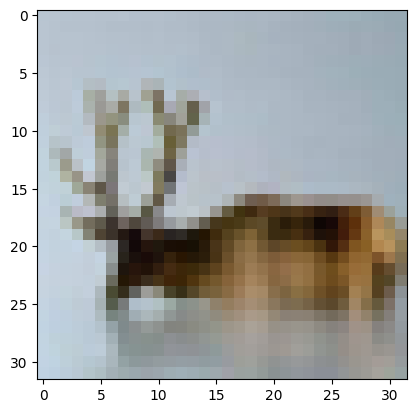

Guess: cat | Label: dog


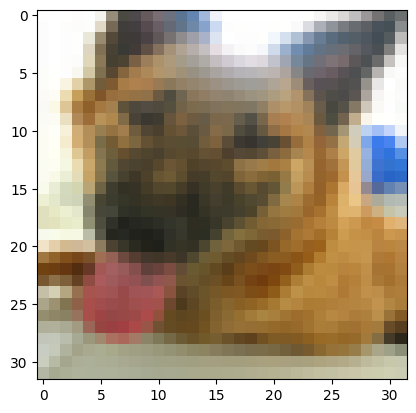

Guess: ship | Label: ship


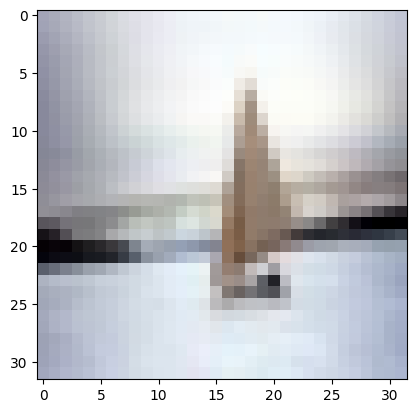

Guess: ship | Label: ship


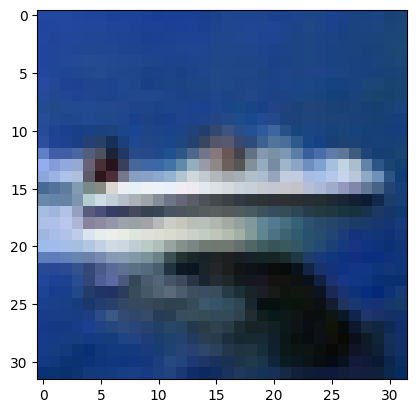

Guess: frog | Label: deer


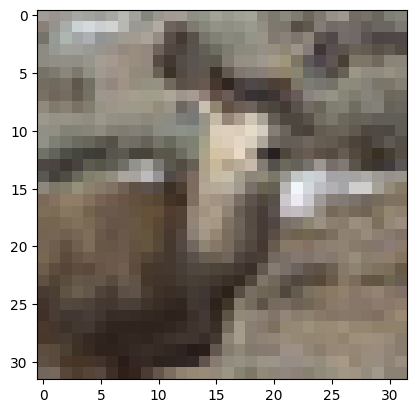

Guess: plane | Label: plane


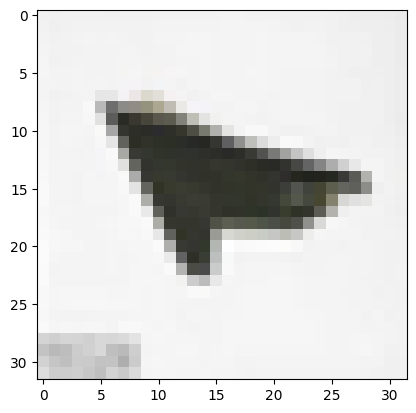

Guess: deer | Label: deer


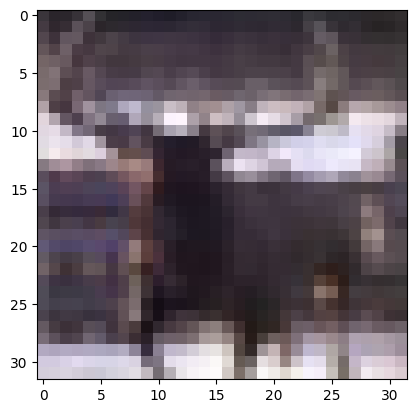

Guess: truck | Label: truck


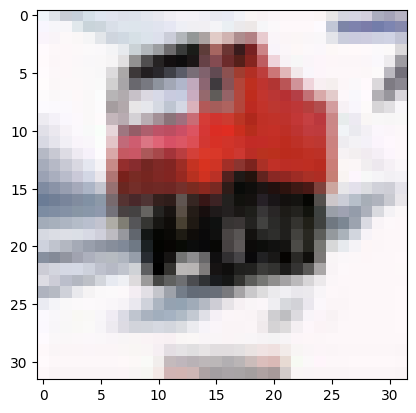

Epoch:  3


0it [00:00, ?it/s]

End of epoch loss: 0.944


0it [00:00, ?it/s]

End of epoch accuracy: 60.95%
Guess: dog | Label: dog


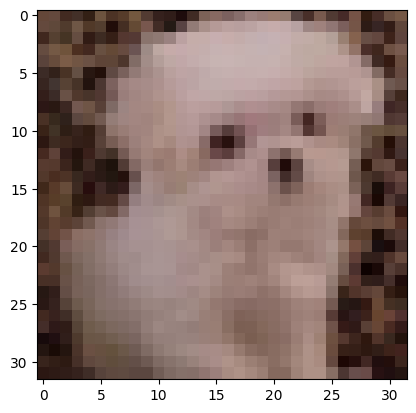

Guess: dog | Label: dog


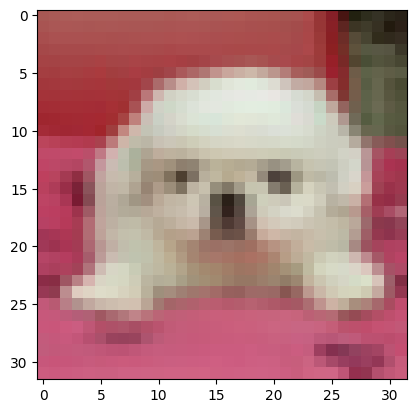

Guess: frog | Label: frog


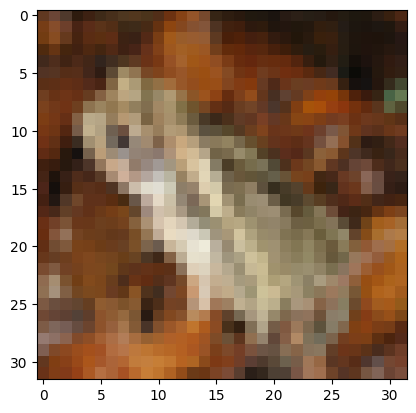

Guess: bird | Label: cat


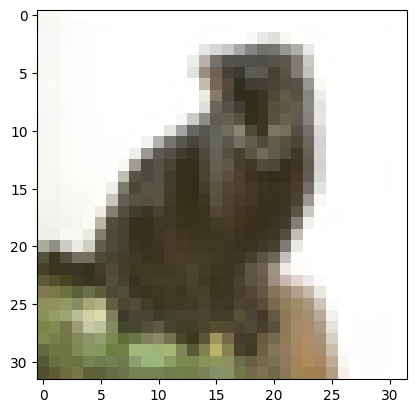

Guess: car | Label: deer


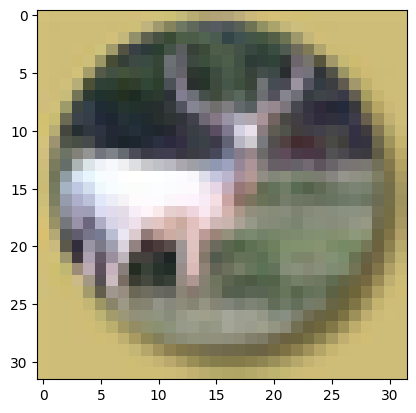

Guess: truck | Label: car


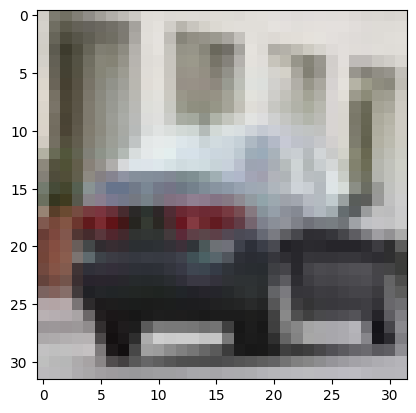

Guess: car | Label: car


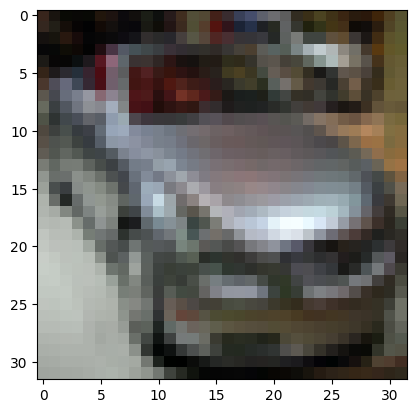

Guess: ship | Label: plane


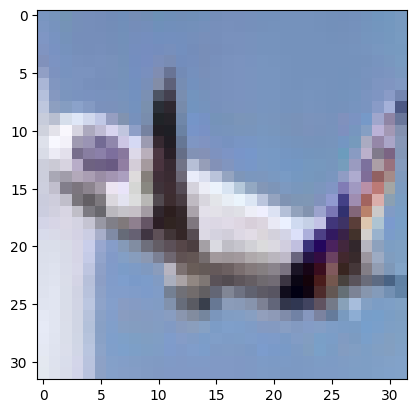

Epoch:  4


0it [00:00, ?it/s]

End of epoch loss: 0.719


0it [00:00, ?it/s]

End of epoch accuracy: 65.19%
Guess: plane | Label: plane


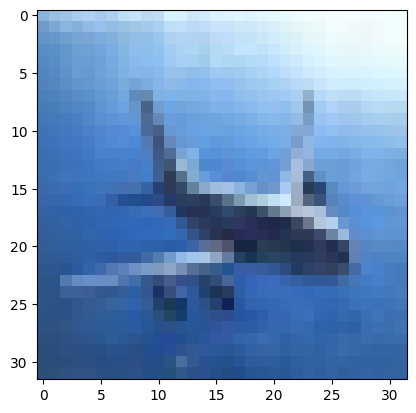

Guess: plane | Label: plane


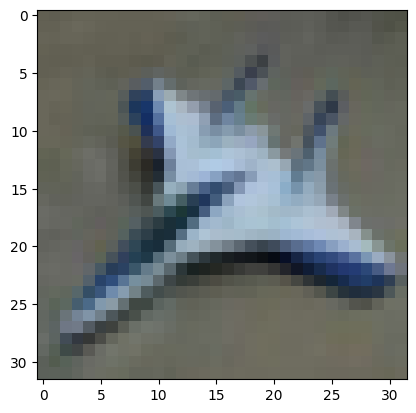

Guess: dog | Label: dog


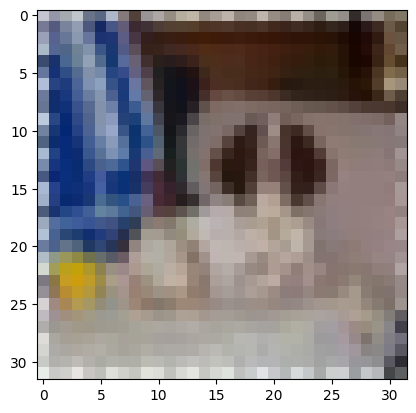

Guess: frog | Label: frog


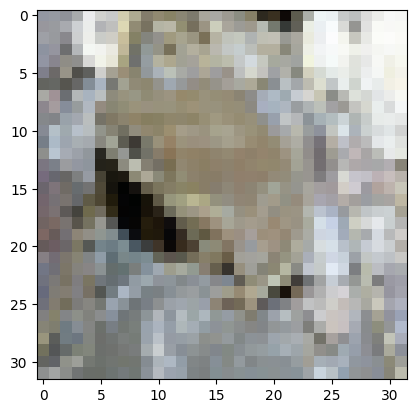

Guess: dog | Label: dog


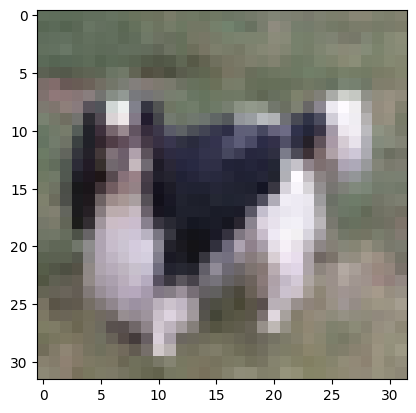

Guess: truck | Label: truck


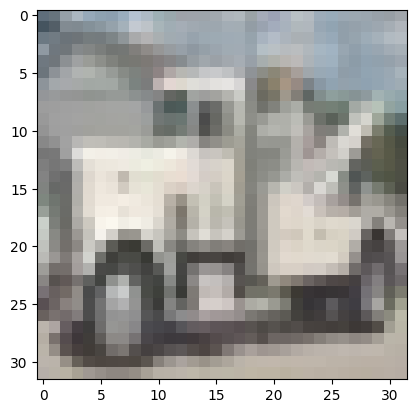

Guess: frog | Label: frog


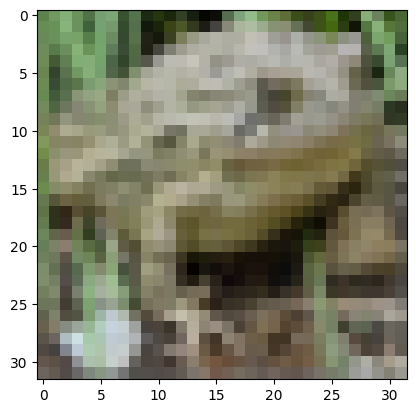

Guess: deer | Label: deer


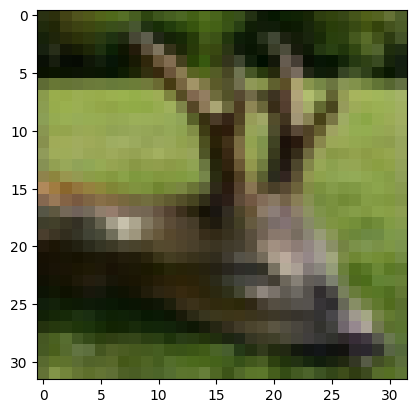

Epoch:  5


0it [00:00, ?it/s]

End of epoch loss: 0.699


0it [00:00, ?it/s]

End of epoch accuracy: 69.91%
Guess: dog | Label: dog


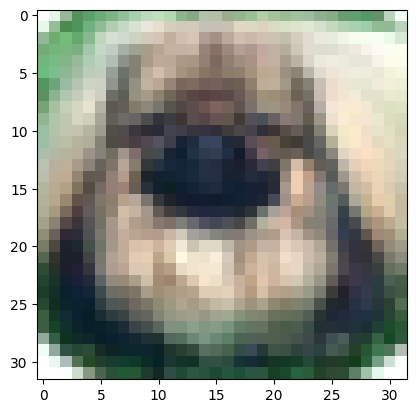

Guess: bird | Label: bird


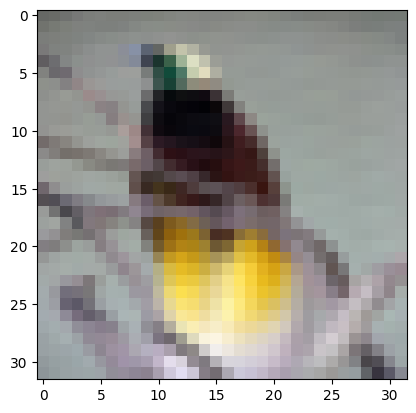

Guess: bird | Label: cat


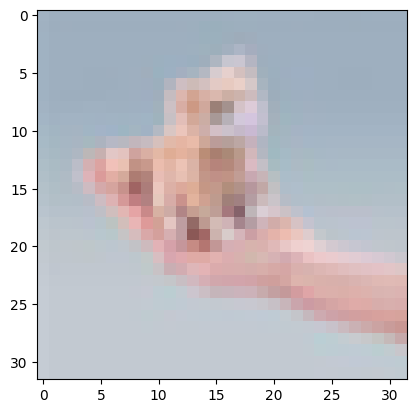

Guess: cat | Label: cat


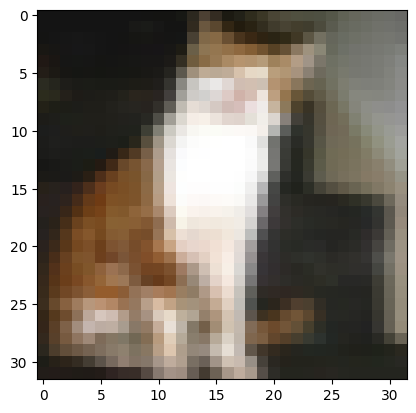

Guess: plane | Label: plane


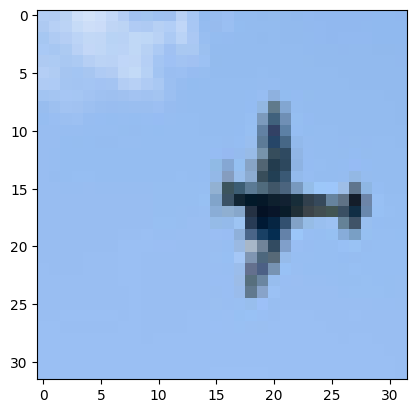

Guess: dog | Label: bird


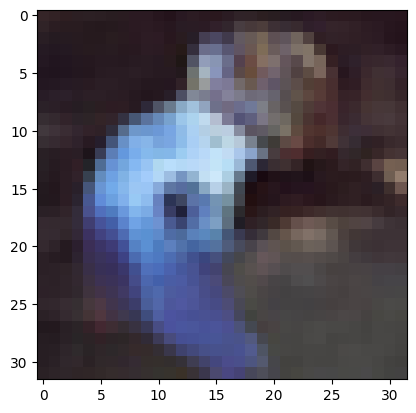

Guess: truck | Label: truck


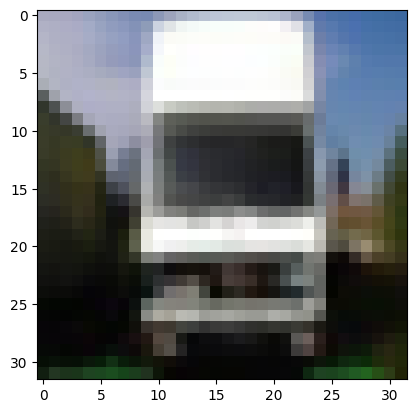

Guess: car | Label: car


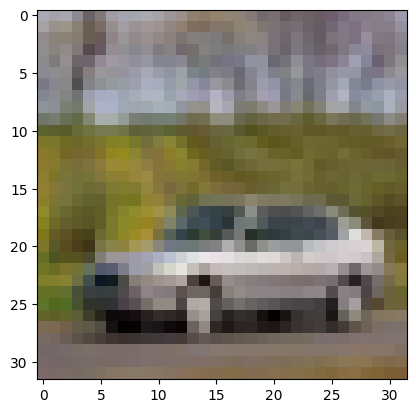

Epoch:  6


0it [00:00, ?it/s]

End of epoch loss: 0.965


0it [00:00, ?it/s]

End of epoch accuracy: 47.37%
Guess: frog | Label: dog


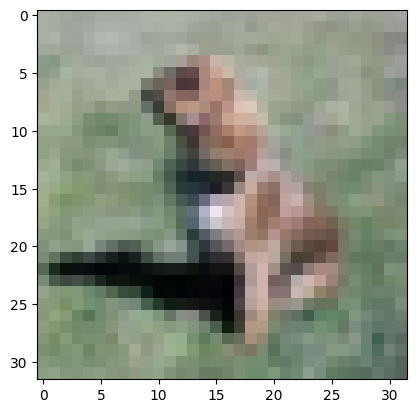

Guess: frog | Label: deer


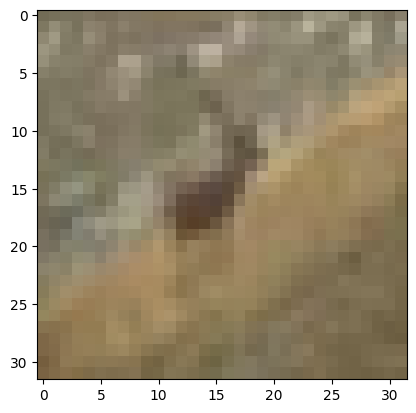

Guess: plane | Label: plane


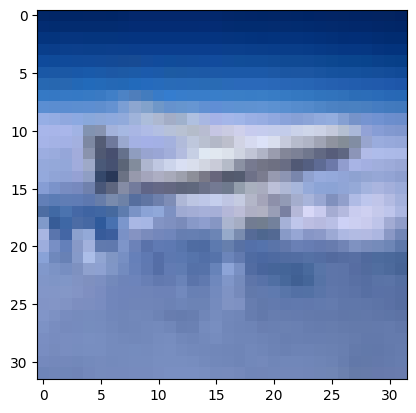

Guess: bird | Label: bird


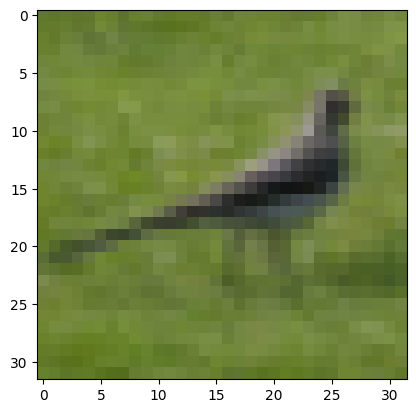

Guess: horse | Label: horse


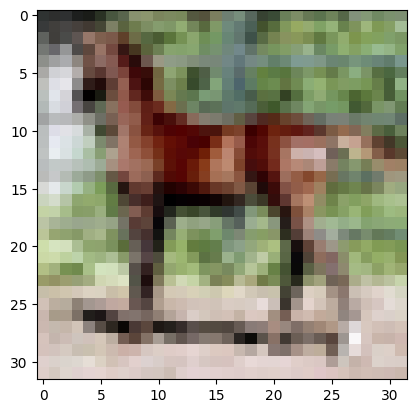

Guess: frog | Label: frog


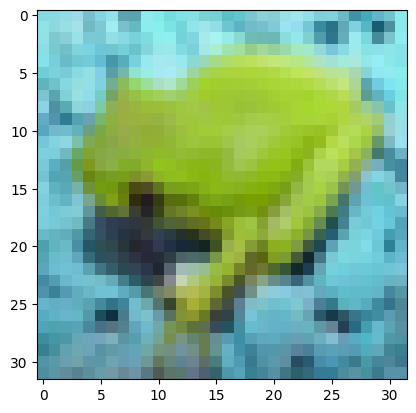

Guess: horse | Label: dog


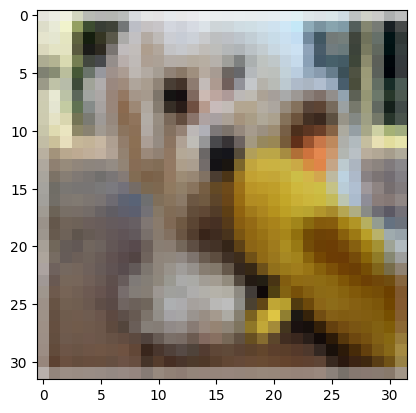

Guess: frog | Label: bird


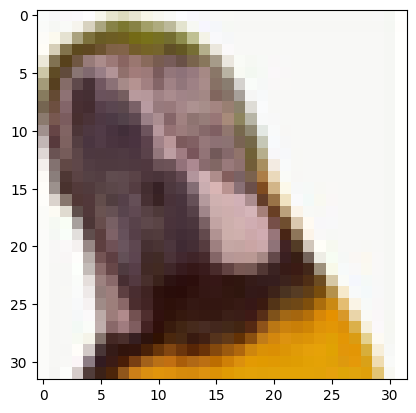

Epoch:  7


0it [00:00, ?it/s]

End of epoch loss: 0.815


0it [00:00, ?it/s]

End of epoch accuracy: 71.66%
Guess: plane | Label: plane


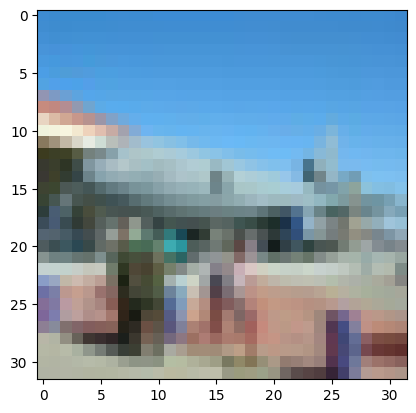

Guess: deer | Label: deer


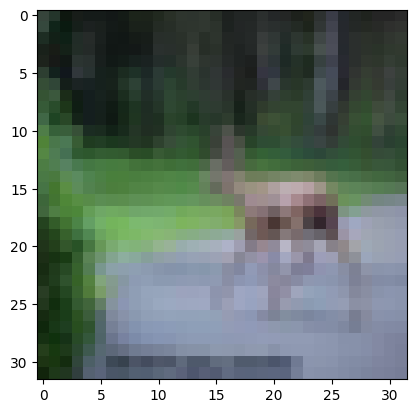

Guess: truck | Label: truck


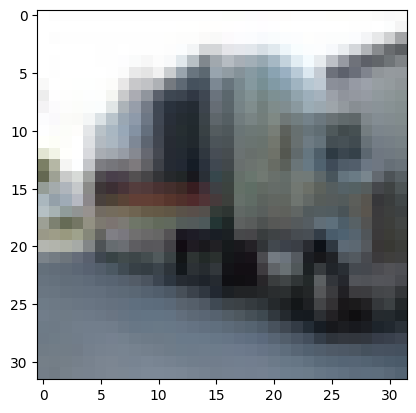

Guess: cat | Label: ship


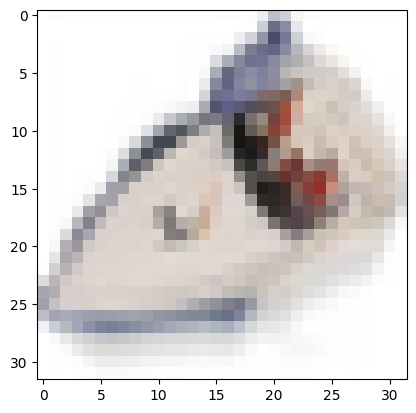

Guess: truck | Label: truck


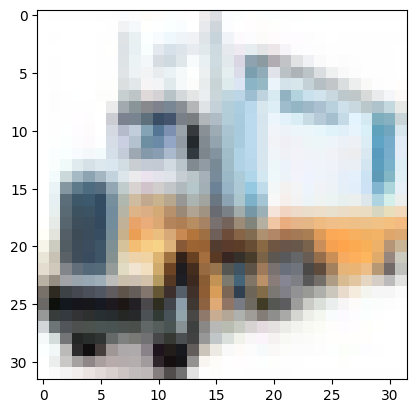

Guess: plane | Label: bird


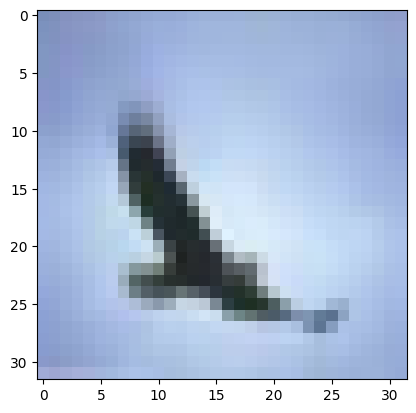

Guess: ship | Label: ship


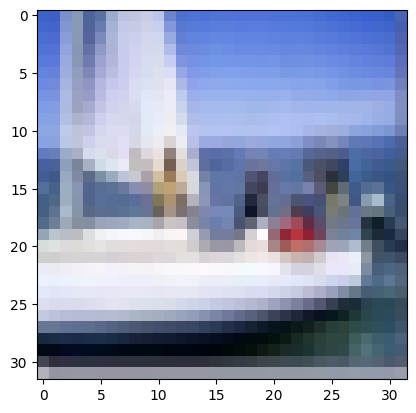

Guess: plane | Label: deer


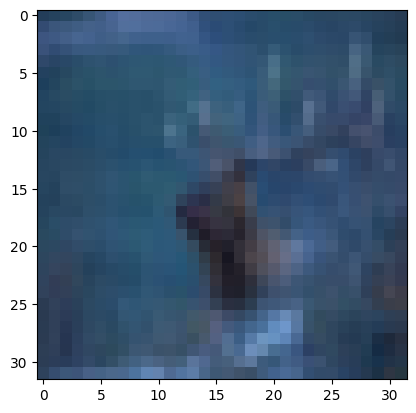

Epoch:  8


0it [00:00, ?it/s]

End of epoch loss: 0.737


0it [00:00, ?it/s]

End of epoch accuracy: 72.52%
Guess: dog | Label: dog


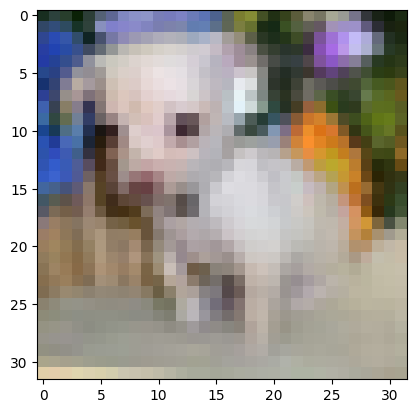

Guess: dog | Label: dog


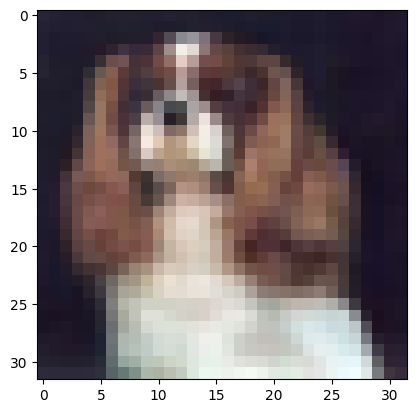

Guess: ship | Label: ship


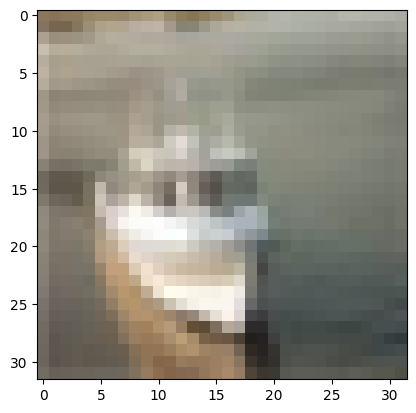

Guess: frog | Label: frog


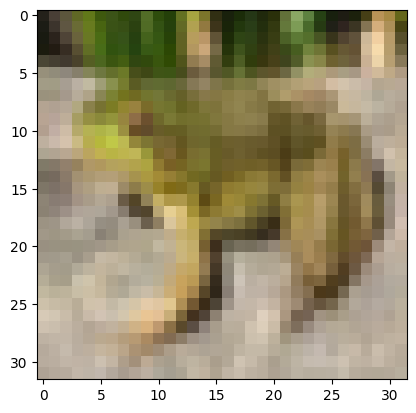

Guess: deer | Label: deer


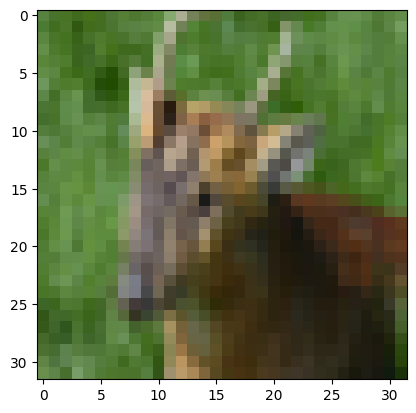

Guess: truck | Label: truck


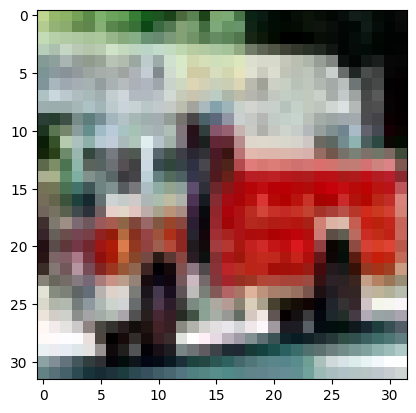

Guess: plane | Label: plane


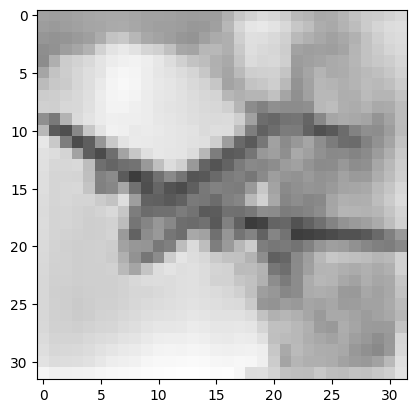

Guess: ship | Label: ship


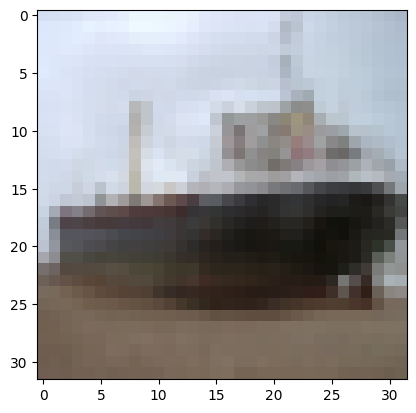

Epoch:  9


0it [00:00, ?it/s]

End of epoch loss: 0.82


0it [00:00, ?it/s]

End of epoch accuracy: 72.02%
Guess: horse | Label: horse


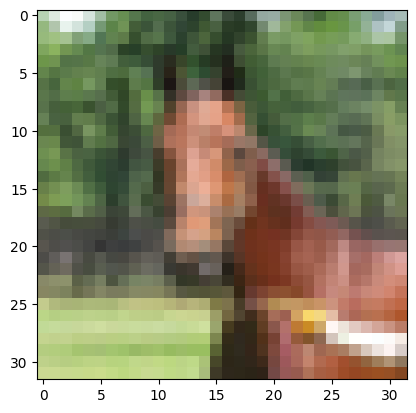

Guess: frog | Label: frog


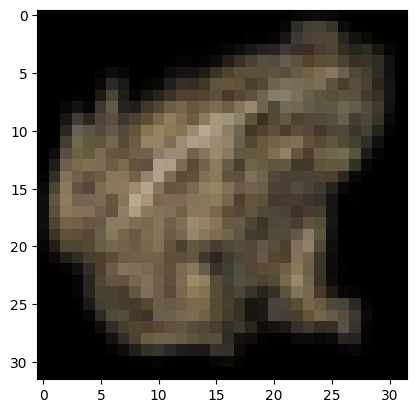

Guess: deer | Label: cat


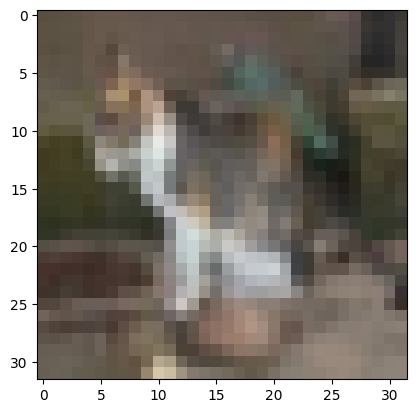

Guess: ship | Label: ship


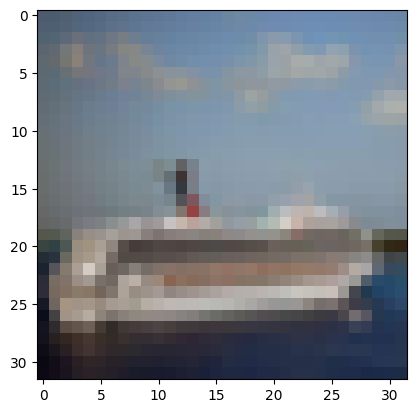

Guess: ship | Label: ship


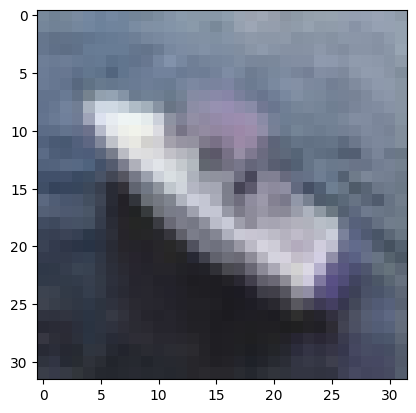

Guess: truck | Label: truck


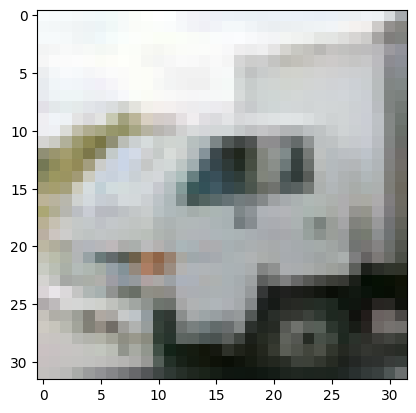

Guess: plane | Label: plane


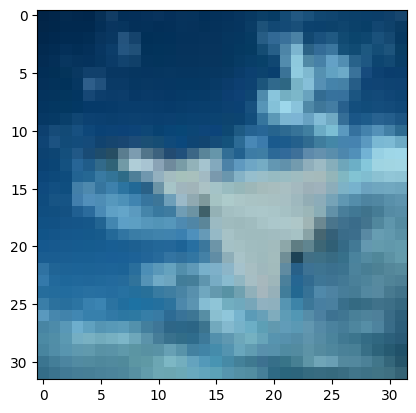

Guess: dog | Label: bird


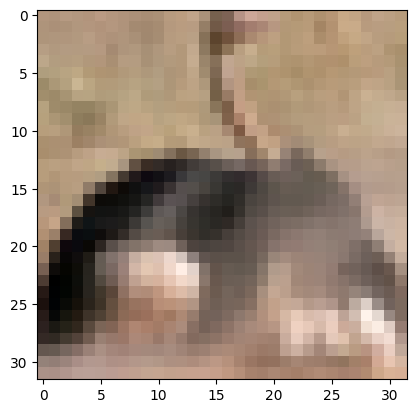

Epoch:  10


0it [00:00, ?it/s]

End of epoch loss: 0.451


0it [00:00, ?it/s]

End of epoch accuracy: 70.14%
Guess: bird | Label: bird


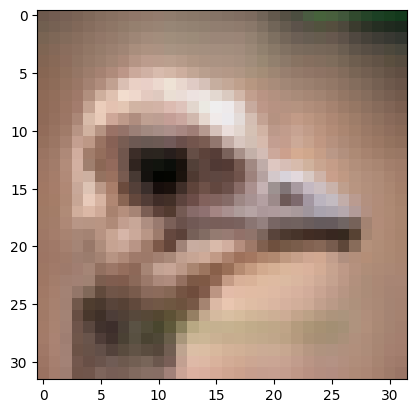

Guess: dog | Label: dog


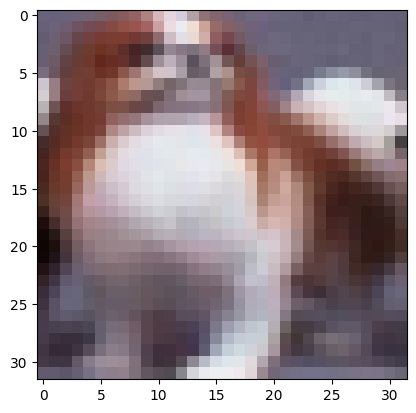

Guess: truck | Label: truck


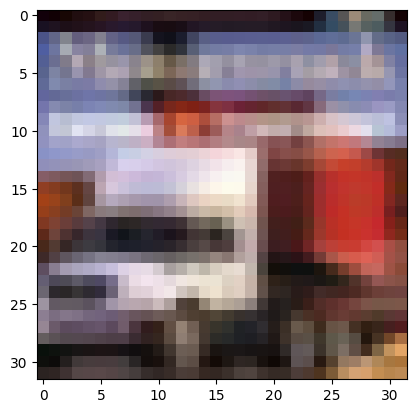

Guess: frog | Label: frog


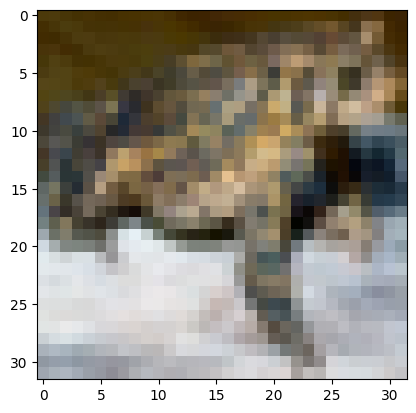

Guess: dog | Label: dog


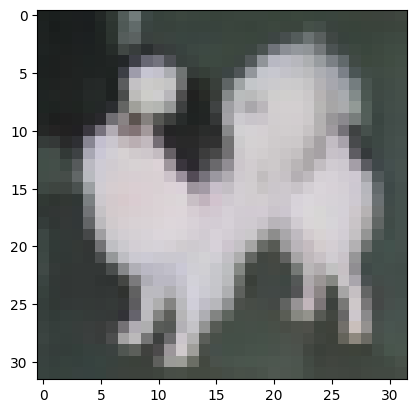

Guess: deer | Label: deer


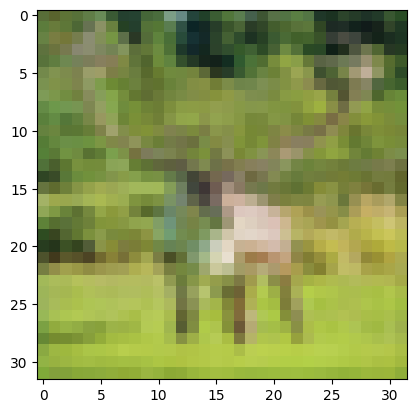

Guess: dog | Label: dog


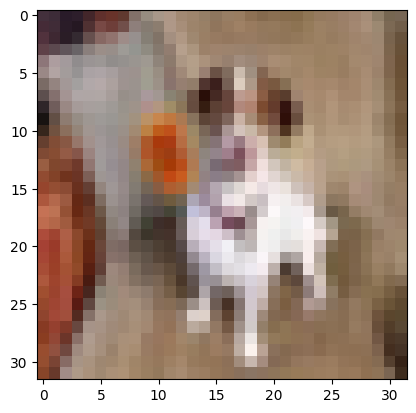

Guess: car | Label: car


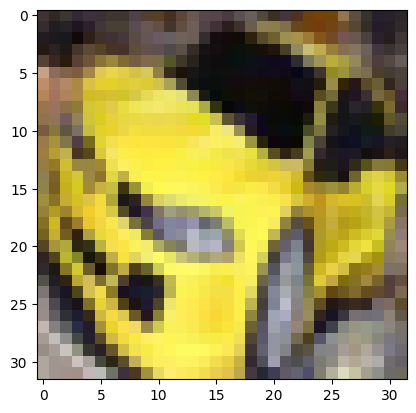

In [12]:
NUM_EPOCHS = 10 # One epoch is one loop through the training data

for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch + 1)
    train_one_epoch(model, train_loader, optimizer, criterion, device)
    test(model, test_loader, device)